This notebook contains research in term of global fidelity.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import dill
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
import sklearn

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import shap
import lime

shap.initjs()

from explainability_confirmation.examine_explanation import examine_interpretation
from explainability_confirmation.examine_explanation import gradual_elimination
from explainability_confirmation.examine_explanation import examine_local_fidelity

import eli5
from eli5.sklearn import PermutationImportance

In [447]:
def get_shap_interpretation(model, X, used_explainer=shap.TreeExplainer, explained_label=1):
    
    explainer = shap.TreeExplainer(model)
    
    shap_values = explainer.shap_values(X)

    
    shap_values = shap_values[explained_label]
    shap_imps = []
    transposed_shap = [*zip(*shap_values)]
    for idx, col in enumerate(transposed_shap):
        shap_imps.append(np.mean(list(map(lambda x: abs(x), col))))
    return shap_imps


# Fico

In [457]:
df = pd.read_csv('heloc_dataset_v1.csv')

target = 'RiskPerformance'
fico_y = (df[target] == 'Bad').astype(int)
fico_X = df.drop(target, axis=1)
feature_names = fico_X.columns
feature_names = [feature + ": " + str(idx+1) for idx, feature in enumerate(feature_names)]


fico_scaler = sklearn.preprocessing.StandardScaler()
fico_scaler.fit(fico_X)
fico_X = fico_scaler.transform(fico_X)

fico_X = pd.DataFrame(fico_X, columns=feature_names)

f_X_train, f_X_test, f_y_train, f_y_test = train_test_split(fico_X, fico_y.values, test_size=0.1, random_state=42)
#X_test_smaller = X_test[:150]




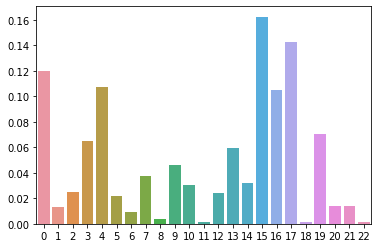

In [202]:
sns.barplot([i for i in range(len(shap_imps))], shap_imps)

In [432]:
f_forest = RandomForestClassifier()
f_forest.fit(f_X_train, f_y_train)

fico_preds = f_forest.predict(f_X_test)
print(accuracy_score(f_y_test, fico_preds))

0.7036328871892925


### AVG SHAP

In [448]:
f_shap = get_shap_interpretation(f_forest, f_X_test)

[0.09130019120458899,
 0.10531548757170162,
 0.12104206500956016,
 0.1314627151051624,
 0.14167304015296367,
 0.1472084130019119,
 0.15426386233269607,
 0.15550669216061175,
 0.15643403441682602,
 0.15837476099426384]

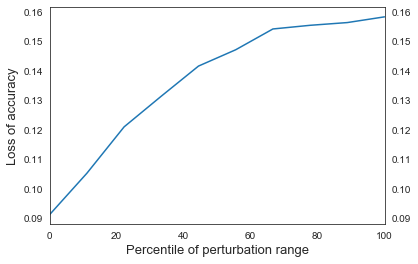

In [508]:
examine_interpretation(f_forest, f_X_test, f_y_test, f_shap, epsilon=23, count_per_step=100)

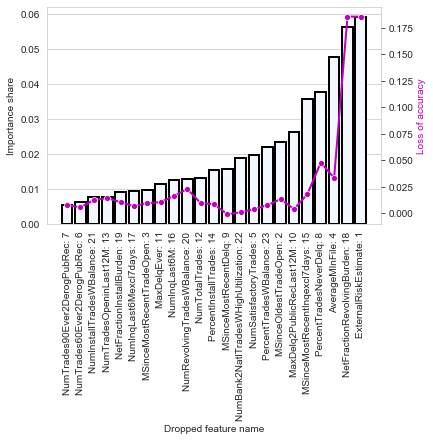

In [475]:
fs = gradual_elimination(f_forest, f_X_test, f_y_test, f_shap)

### PERM

[0.09963671128107077,
 0.11267686424474177,
 0.13414913957934993,
 0.14594646271510514,
 0.14724665391969405,
 0.14843212237093684,
 0.15437858508604207,
 0.15382409177820267,
 0.15426386233269596,
 0.1519311663479923]

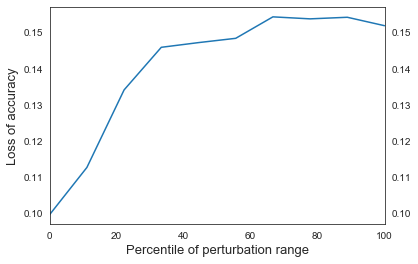

In [515]:
examine_interpretation(f_forest, f_X_test, f_y_test, f_perm, epsilon=23, count_per_step=50)

In [476]:
f_perm = PermutationImportance(f_forest).fit(f_X_test, f_y_test).feature_importances_

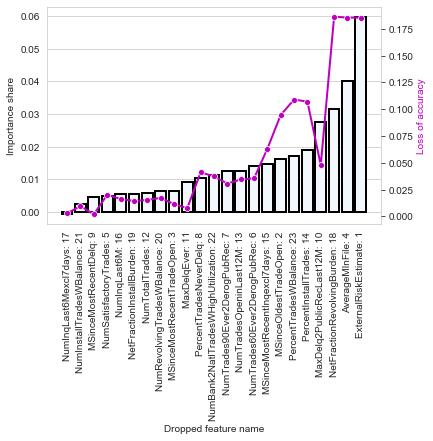

In [503]:
fp = gradual_elimination(f_forest, f_X_test, f_y_test, f_perm)

# Titanic

In [3]:
titanic_train = pd.read_csv('titanic_train.csv')

titanic_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

titanic_train['Age'].fillna(titanic_train['Age'].median(), inplace=True)
titanic_train['Embarked'].fillna('S', inplace=True)

titanic_train['Sex'] = (titanic_train['Sex'] == 'female').astype(int)
titanic_train['Fare'] = titanic_train['Fare'].astype(int)

titanic_train['Embarked'] = titanic_train['Embarked'].map({'Q': 0, 'C': 1, 'S': 2})

titanic_X = titanic_train.drop(['Survived'], axis=1)
titanic_y = titanic_train['Survived']

titanic_scaler = sklearn.preprocessing.StandardScaler()
titanic_scaler.fit()

#titanic_X = tf.keras.utils.normalize(titanic_X, axis=1)

titanic_X_train, titanic_X_test, titanic_y_train, titanic_y_test = train_test_split(titanic_X, titanic_y, test_size=0.2, random_state=42)

TypeError: fit() missing 1 required positional argument: 'X'

# Iris 
Multi class clasification

In [344]:
data = sklearn.datasets.load_iris()

In [354]:
iris_data = sklearn.datasets.load_iris()
iris_X = iris_data.data
iris_y = iris_data.target
iris_X = pd.DataFrame(iris_X, columns=iris_data.feature_names)


i_X_train, i_X_test, i_y_train, i_y_test = train_test_split(iris_X, iris_y, test_size=0.2, random_state=42)

In [355]:
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(i_X_train, i_y_train)

tree_preds = tree.predict(i_X_test)
print(accuracy_score(i_y_test, tree_preds))


0.9666666666666667


In [356]:
i_forest_model = RandomForestClassifier()
i_forest_model.fit(i_X_train, i_y_train)
i_forest_preds = i_forest_model.predict(i_X_test)
print(accuracy_score(i_y_test, i_forest_preds))

1.0


### AVG SHAP

In [362]:
i_shap_vals = get_shap_interpretation(i_forest_model, i_X_train)

[0.04599999999999993,
 0.18200000000000005,
 0.29733333333333334,
 0.351,
 0.3849999999999999,
 0.42700000000000005,
 0.44866666666666666,
 0.4666666666666667,
 0.4646666666666667,
 0.485]

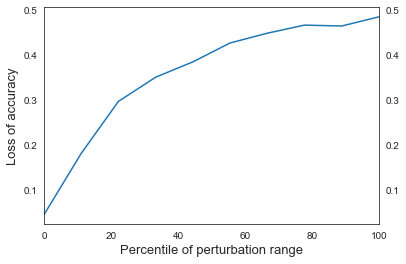

In [325]:
examine_interpretation(i_forest_model, i_X_test, i_y_test, i_shap_vals, count_per_step=100, epsilon=8)

,0,1,Feature names,Loss of accuracy
0,1,0.012362,sepal width (cm),0.000000
1,0,0.019760,sepal length (cm),0.000000
2,3,0.192339,petal width (cm),0.033333
3,2,0.226650,petal length (cm),0.700000


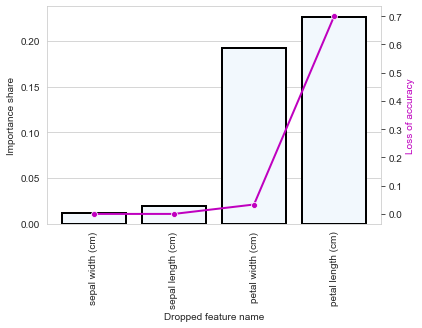

In [377]:
gradual_elimination(i_forest_model, i_X_test, i_y_test, i_shap_vals)

### PERM IMP

In [319]:
i_perm = PermutationImportance(i_forest_model).fit(i_X_test, i_y_test).feature_importances_

[0.16066666666666662,
 0.241,
 0.3233333333333335,
 0.3850000000000001,
 0.42366666666666664,
 0.45666666666666667,
 0.4650000000000001,
 0.4740000000000001,
 0.4850000000000001,
 0.4826666666666667]

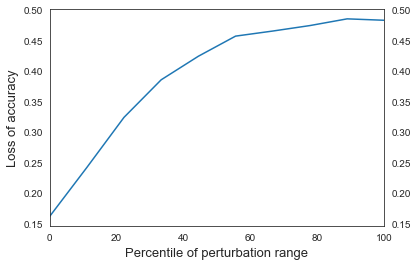

In [324]:
examine_interpretation(i_forest_model, i_X_test, i_y_test, i_perm, count_per_step=100, epsilon=8)

,0,1,Feature names,Loss of accuracy
0,0,0.00,sepal length (cm),0.000000
1,1,0.00,sepal width (cm),0.000000
2,3,0.26,petal width (cm),0.033333
3,2,0.34,petal length (cm),0.700000


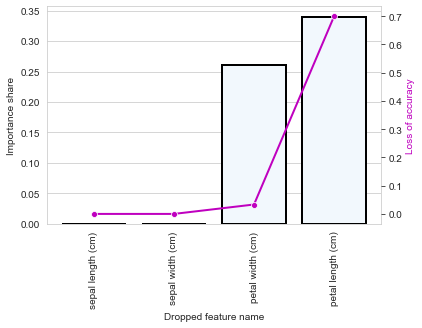

In [376]:
gradual_elimination(i_forest_model, i_X_test, i_y_test, i_perm)

# Wine
Multi class classification, 13 features

In [386]:
wine_data = sklearn.datasets.load_wine()
wine_X = wine_data.data
wine_y = wine_data.target

wine_scaler = sklearn.preprocessing.StandardScaler()
wine_scaler.fit(wine_X)
wine_X = wine_scaler.transform(wine_X)

wine_X = pd.DataFrame(wine_X, columns=wine_data.feature_names)
w_X_train, w_X_test, w_y_train, w_y_test = train_test_split(wine_X, wine_y, test_size=0.4, random_state=42)

In [387]:
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(w_X_train, w_y_train)

tree_preds = tree.predict(w_X_test)
print(accuracy_score(w_y_test, tree_preds))

0.875


In [388]:
w_forest_model = RandomForestClassifier()
w_forest_model.fit(w_X_train, w_y_train)
w_forest_preds = w_forest_model.predict(w_X_test)
print(accuracy_score(w_y_test, w_forest_preds))

0.9861111111111112


### AVG SHAP

In [389]:
w_shap_vals = get_shap_interpretation(w_forest_model, w_X_train)

[0.18263888888888868,
 0.21986111111111128,
 0.2786111111111108,
 0.32680555555555546,
 0.34472222222222215,
 0.3538888888888888,
 0.35944444444444446,
 0.3783333333333333,
 0.3698611111111111,
 0.36458333333333337]

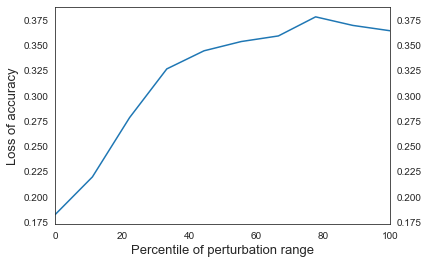

In [282]:
examine_interpretation(w_forest_model, w_X_test, w_y_test, wine_shap_vals, count_per_step=100, epsilon=20)

,0,1,Feature names,Loss of accuracy
0,7,0.006515,nonflavanoid_phenols,0.000000
1,2,0.007404,ash,0.000000
2,1,0.012570,malic_acid,-0.013889
3,4,0.013347,magnesium,-0.013889
4,3,0.014049,alcalinity_of_ash,-0.013889
5,8,0.020783,proanthocyanins,0.027778
6,5,0.025139,total_phenols,0.000000
7,10,0.034175,hue,0.041667
8,11,0.058606,od280/od315_of_diluted_wines,0.125000
9,6,0.060754,flavanoids,0.250000


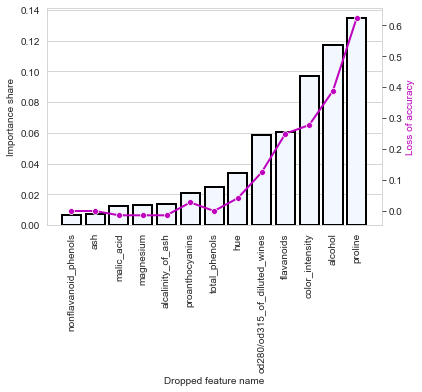

In [390]:
gradual_elimination(w_forest_model, w_X_test, w_y_test, w_shap_vals)

### PERM IMPS

In [391]:
w_perm = PermutationImportance(w_forest_model).fit(w_X_test, w_y_test)

[0.2069444444444446,
 0.2652777777777777,
 0.31361111111111106,
 0.33444444444444443,
 0.3481944444444445,
 0.35250000000000004,
 0.34791666666666665,
 0.33999999999999997,
 0.33777777777777773,
 0.3309722222222222]

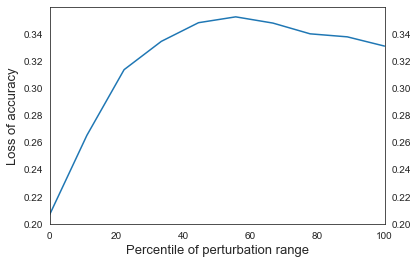

In [285]:
examine_interpretation(w_forest_model, w_X_test, w_y_test, w_perm.feature_importances_, count_per_step=100, epsilon=20)

,0,1,Feature names,Loss of accuracy
0,1,-1.388889e-02,malic_acid,-0.013889
1,3,0.000000e+00,alcalinity_of_ash,-0.013889
2,4,0.000000e+00,magnesium,-0.013889
3,7,0.000000e+00,nonflavanoid_phenols,-0.013889
4,8,4.440892e-17,proanthocyanins,0.027778
5,2,8.333333e-03,ash,0.027778
6,10,1.111111e-02,hue,0.069444
7,5,1.666667e-02,total_phenols,0.041667
8,9,4.722222e-02,color_intensity,0.097222
9,11,5.000000e-02,od280/od315_of_diluted_wines,0.152778


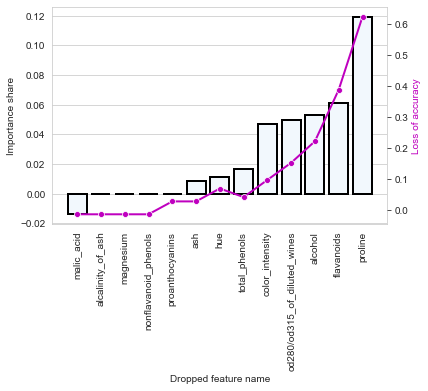

In [392]:
gradual_elimination(w_forest_model, w_X_test, w_y_test, w_perm.feature_importances_)

### Compare improtances

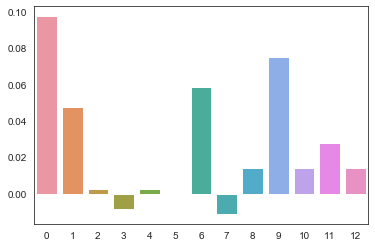

In [273]:
sns.barplot(x=[i for i in range(len(s))],y=perm.feature_importances_)

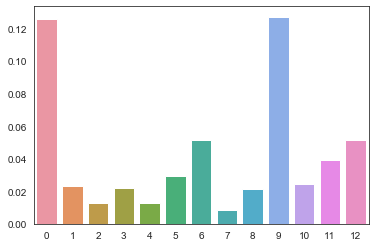

In [274]:
sns.barplot(x=[i for i in range(len(s))],y=s)

In [258]:
def get_shap_interpretation(model, X, used_explainer=shap.TreeExplainer, explained_label=1):
    
    explainer = used_explainer(model, X)
    shap_values = explainer.shap_values(X)
#     return shap_values
    shap_values = shap_values[explained_label]
    shap_imps = []
    transposed_shap = [*zip(*shap_values)]
    for idx, col in enumerate(transposed_shap):
        shap_imps.append(np.mean(list(map(lambda x: abs(x), col))))
    return shap_imps



# Breast cancer
Binary classification
30 features

In [395]:
b_data = sklearn.datasets.load_breast_cancer()
b_X = b_data.data
b_y = b_data.target

b_scaler = sklearn.preprocessing.StandardScaler()
b_scaler.fit(b_X)
b_X = b_scaler.transform(b_X)

b_X = pd.DataFrame(b_X, columns=b_data.feature_names)
b_X_train, b_X_test, b_y_train, b_y_test = train_test_split(b_X, b_y, test_size=0.2, random_state=42)

In [396]:
b_tree = DecisionTreeClassifier(max_depth=4)
b_tree.fit(b_X_train, b_y_train)

b_tree_preds = b_tree.predict(b_X_test)
print(accuracy_score(b_y_test, b_tree_preds))

0.9385964912280702


In [397]:
b_forest = RandomForestClassifier()
b_forest.fit(b_X_train, b_y_train)

b_forest_preds = b_forest.predict(b_X_test)
print(accuracy_score(b_y_test, b_forest_preds))

0.9473684210526315


### AVG SHAP

In [398]:
b_shap = get_shap_interpretation(b_forest, b_X_train)

[0.1084210526315793,
 0.16289473684210543,
 0.2198245614035086,
 0.2527192982456139,
 0.2761403508771929,
 0.2935964912280702,
 0.2968421052631579,
 0.30236842105263173,
 0.3073684210526316,
 0.30991228070175436]

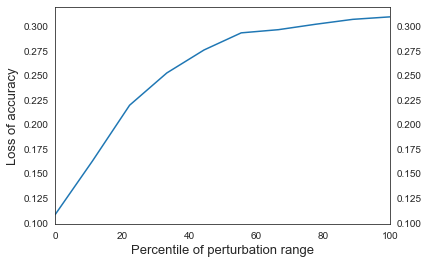

In [290]:
examine_interpretation(b_forest, b_X_test, b_y_test, b_shap, count_per_step=100, epsilon=35)

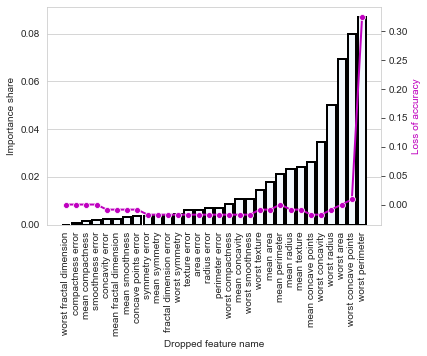

In [405]:
bs = gradual_elimination(b_forest, b_X_test, b_y_test, b_shap)

In [407]:
bs = gradual_elimination(b_forest, b_X_test, b_y_test, b_shap)

<Figure size 432x288 with 0 Axes>

### PERM IMPS

In [399]:
b_perm = PermutationImportance(b_forest).fit(b_X_test, b_y_test)

[0.14482456140350908,
 0.180964912280702,
 0.2185964912280699,
 0.24263157894736853,
 0.2598245614035085,
 0.27035087719298223,
 0.26640350877192975,
 0.2755263157894736,
 0.27140350877192965,
 0.27368421052631564]

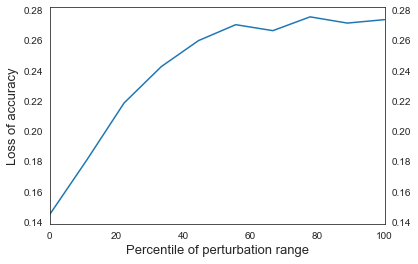

In [313]:
examine_interpretation(b_forest, b_X_test, b_y_test, b_perm.feature_importances_, count_per_step=100, epsilon=35)

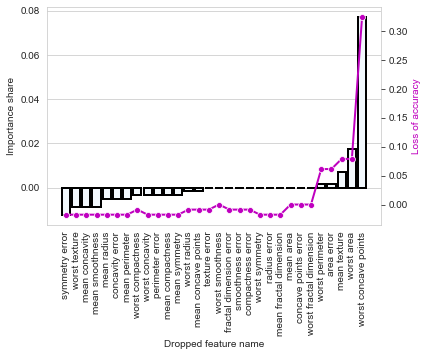

In [402]:
bp = gradual_elimination(b_forest, b_X_test, b_y_test, b_perm.feature_importances_)